# Gaussian Density Filtering for predicting mid price raise in LOBs for 9062

In this notebook we present results of prediction if the mid price of LOB will raise in next tick. For data preparation we use GDF filters with various parameters `r` and `s`.

For prediction we use SVM - we will use 4 features for predictions, which will be described in later parts.

This notebook contains information which parameters for GDF and SVM were the best.

In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np
import itertools
import os

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

In [2]:
r = 0.01
s = 0.1
ss = [0.1, 0.2, 0.3, 0.4, 0.5]
rr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
K = 50
length = 10000

stock = 1472

K1 = 23
K2 = 27
df_res = pd.DataFrame()
for r in rr:
    for s in ss:
        try:
            filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, K1, K2)
            df = pd.read_csv(filename)
            df_res = df_res.append(df, ignore_index=True)
        except Exception as e:
            pass
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.apply(pd.to_numeric)
df_res.dropna(axis=0, inplace=True)
df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock
1,1,50,10,0.01,0.548110,0.555776,0.1,1472
2,1,50,100,0.01,0.560224,0.554721,0.1,1472
3,1,50,1000,0.01,0.548124,0.564162,0.1,1472
4,1,50,10000,0.01,0.539365,0.568039,0.1,1472
5,10,50,1,0.01,0.546704,0.555776,0.1,1472


## Results

We train SVM with `rbf` kernel on *training* dataset. Next we hypertune `gamma` and `C` parameters on *validation* dataset. After that we pick the best parameters for training algorithm and test how it performs on *testting* dataset.


We pick 4 features for prediction:

* filtered column number 28-32 # TODO: picture?

Parameters r:
* for r in np.arange(0.01, 0.11, step=0.01)

Parameters s:
* for s in np.arange(0.1, 0.6, step=0.1)

SVM parameters:
* `gamma` - # TODO
* `C` - # TODO

TODO: describe against what we are comparing 

In [3]:
df_res['roc_log_cv'] = np.zeros(len(df_res)) - 1
df_res['roc_log_train'] = np.zeros(len(df_res)) - 1
roc_log_cv = []
res_log = roc_results.result_cv_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log[str(int(row['stock']))])
df_res['roc_log_cv'] = roc_log_cv


roc_log_train = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_train.append(res_log[str(int(row['stock']))])
df_res['roc_log_train'] = roc_log_train

df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train
1,1,50,10,0.01,0.548110,0.555776,0.1,1472,0.558029,0.560898
2,1,50,100,0.01,0.560224,0.554721,0.1,1472,0.558029,0.560898
3,1,50,1000,0.01,0.548124,0.564162,0.1,1472,0.558029,0.560898
4,1,50,10000,0.01,0.539365,0.568039,0.1,1472,0.558029,0.560898
5,10,50,1,0.01,0.546704,0.555776,0.1,1472,0.558029,0.560898


## Tunning of `r` and `s` parameters for filters

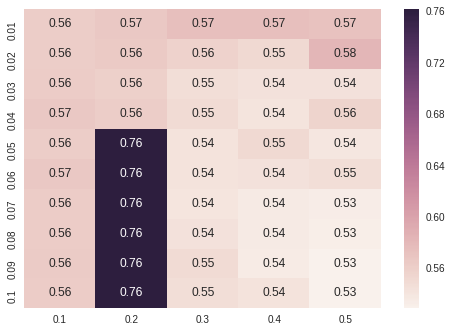

In [4]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=rr, columns=ss)
for i, row in df_res.groupby(['r', 's']).max().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

### SVM hyperparameter tunnig (`gamma` and `C`)

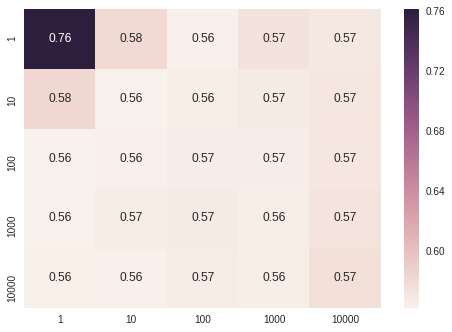

In [5]:
df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
for i, row in df_res.groupby(['C', 'gamma']).max().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

In [6]:
from itertools import product

cs = sorted(df_res['C'].unique())
gammas = sorted(df_res['gamma'].unique())

svm_params = product(gammas, cs)
gdf_params = list(product([int(r*100) for r in rr], [int(s*100) for s in ss]))


df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=list(svm_params), columns=list(gdf_params))

for i, row in df_res.iterrows():
    r = int(row['r'] * 100)
    s = int(row['s'] * 100)
    column = (r, s)
    index = (row['C'], row['gamma'])
    df_g[column].loc[index] = row['roc_train']
df_g = df_g.apply(pd.to_numeric)   
df_g.head()

,"(1, 10)","(1, 20)","(1, 30)","(1, 40)","(1, 50)","(2, 10)","(2, 20)","(2, 30)","(2, 40)","(2, 50)",...,"(9, 10)","(9, 20)","(9, 30)","(9, 40)","(9, 50)","(10, 10)","(10, 20)","(10, 30)","(10, 40)","(10, 50)"
"(1, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.513975,NaN,NaN,NaN,NaN,0.521876,NaN,NaN,NaN
"(1, 10)",0.555776,0.557671,0.600563,NaN,NaN,0.557464,0.553454,0.556268,0.555580,0.620344,...,0.571156,0.555321,0.546045,0.550928,0.542176,0.567688,0.555570,0.546584,0.546898,0.544139
"(1, 100)",0.554721,0.563081,0.553919,0.563795,0.564903,0.558591,0.560864,0.559124,0.552839,0.551384,...,0.561801,0.556150,0.553265,0.545418,0.542076,0.562802,0.556585,0.555046,0.547995,0.545040
"(1, 1000)",0.564162,0.561748,0.562327,0.562329,0.569051,0.561624,0.560691,0.556477,0.556133,0.559994,...,0.569447,0.561241,0.554192,0.550049,0.550025,0.569238,0.561068,0.551978,0.549298,0.546172
"(1, 10000)",0.568039,0.573847,0.568786,0.567522,0.566293,0.571453,0.579143,0.569789,0.565796,0.559169,...,0.585332,0.589179,0.612851,0.604705,0.599404,0.584471,0.588434,0.616317,0.604019,0.605060


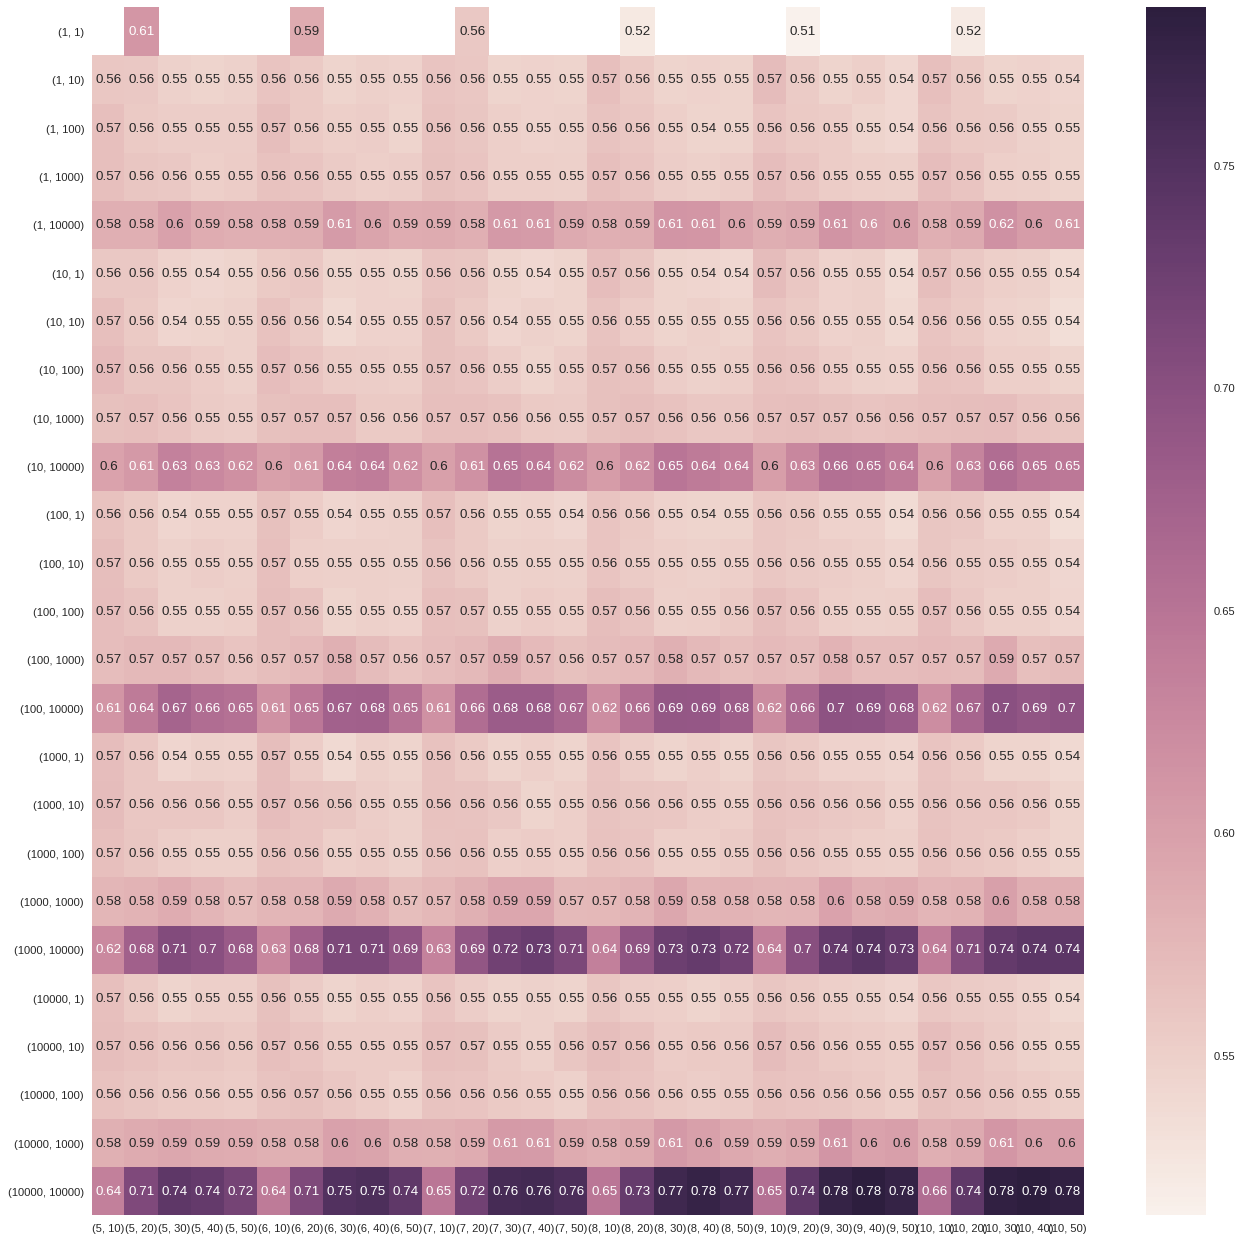

In [7]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
gdf_params_10 = [g for g in list(gdf_params) if g[0] >= 5]
sns.heatmap(df_g[gdf_params_10], annot=True)

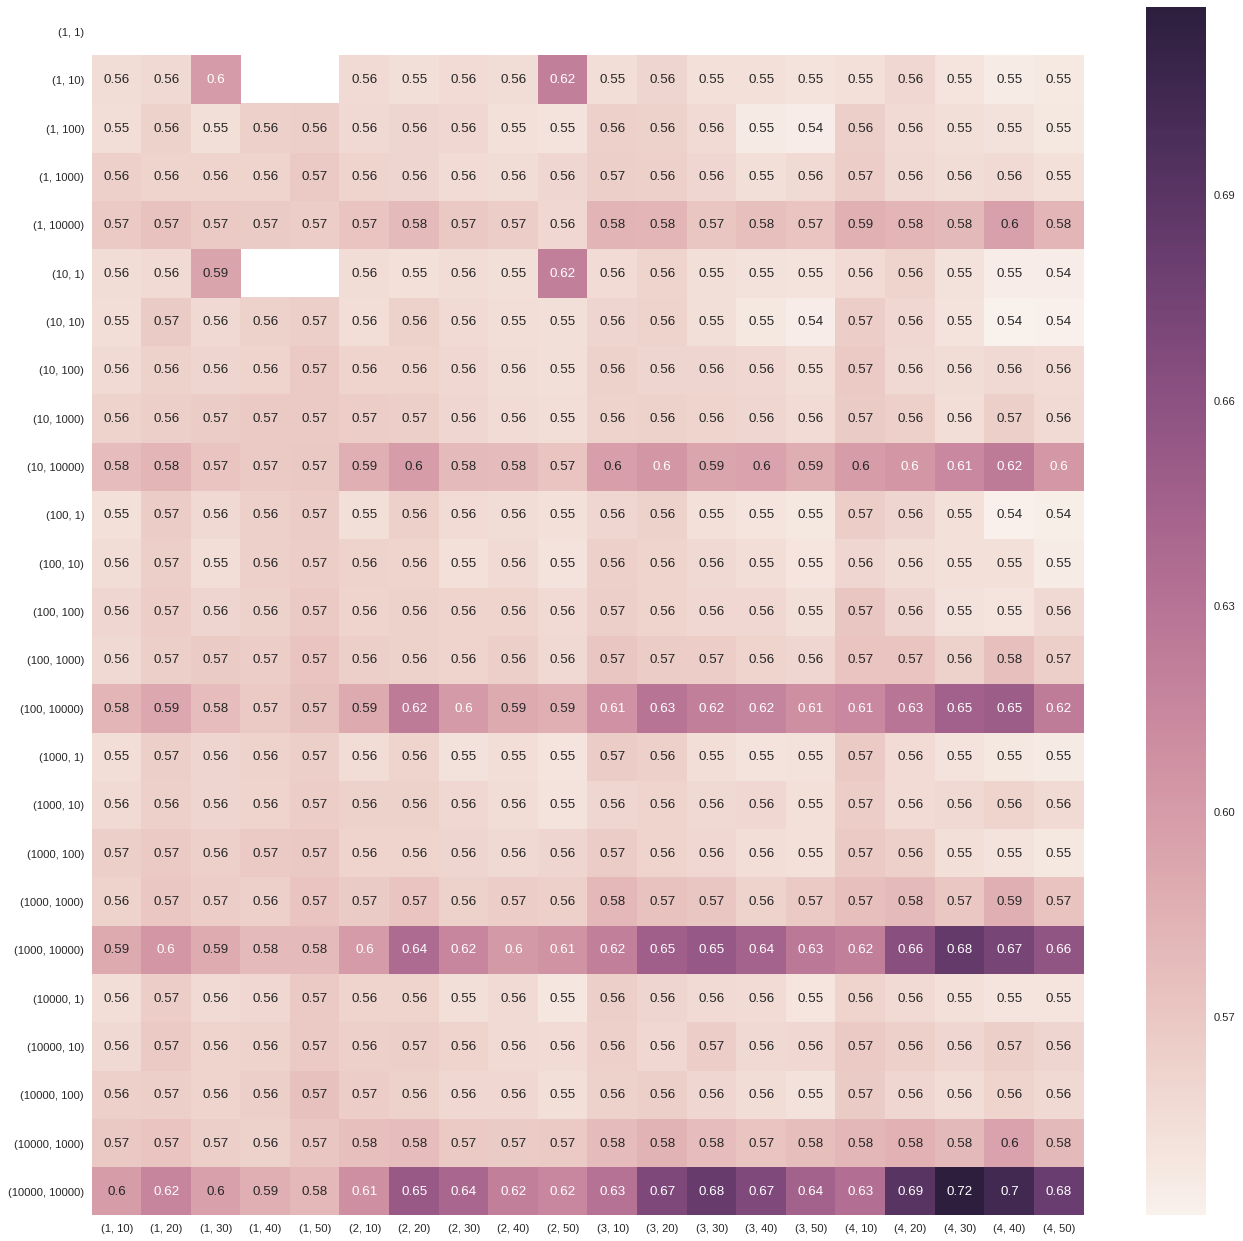

In [8]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
gdf_params_5 = [g for g in list(gdf_params) if g[0] < 5]
sns.heatmap(df_g[gdf_params_5], annot=True)

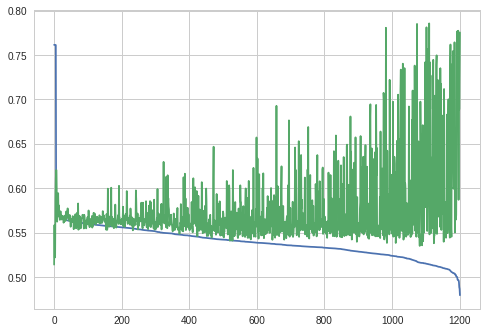

In [9]:
plt.plot(df_res['roc_cv'].values)
plt.plot(df_res['roc_train'].values)

## Learning curves

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def read_gdf_data(stock, r, s, K=50, length=10000):
    filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
    if not os.path.exists(os.path.join('data_gdf',  filename + '.csv')):
        print('GDF file ', filename, 'does not exist')
    try:
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='data_gdf/', cv=True, length=length)
        if dfs is None:
            print('none')
    except Exception as e:
        print(filename, 'not read', e)
    return dfs, dfs_cv, dfs_test

def plot_svm_learning_curve(df, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    clf.fit(X, y)
    plot_learning_curve(clf, X, y)
    return clf

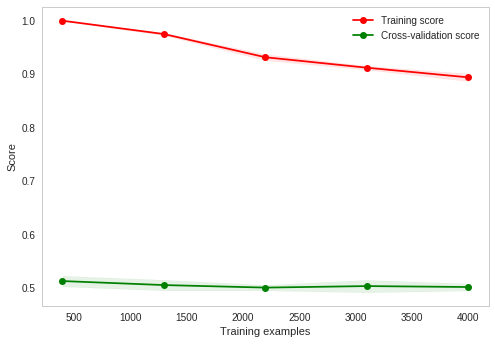

In [11]:
row = df_res.max()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']

df, df_cv, df_test = read_gdf_data(stock, r, s)
clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

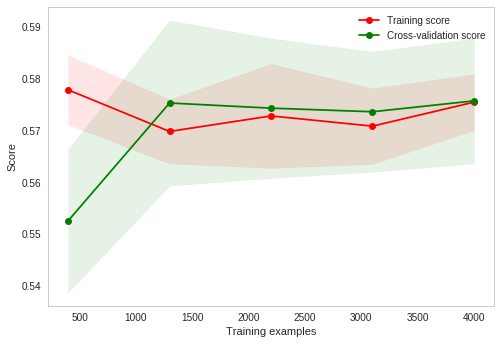

In [12]:
row = df_res.min()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']

df, df_cv, df_test = read_gdf_data(stock, r, s)
clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

### Validation curve

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


def plot_validation_curve(df, c_range, gamma_range, c_start=1, gamma_start=1):
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    train_scores, test_scores = validation_curve(
        SVC(kernel='rbf', C=c_start), X, y, param_name="gamma", param_range=gamma_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(gamma_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(gamma_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(gamma_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(gamma_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    
    train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', gamma=gamma_start), X, y, param_name="C", param_range=c_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(c_range, train_scores_mean, label="Training score C",
                 color="red", lw=lw)
    plt.fill_between(c_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.semilogx(c_range, test_scores_mean, label="Cross-validation score C",
                 color="green", lw=lw)
    plt.fill_between(c_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="green", lw=lw)
    
    
    plt.legend(loc="best")

C                   1.000000
K                  50.000000
gamma               1.000000
r                   0.010000
roc_cv              0.479516
roc_train           0.513975
s                   0.100000
stock            1472.000000
roc_log_cv          0.558029
roc_log_train       0.560898
dtype: float64


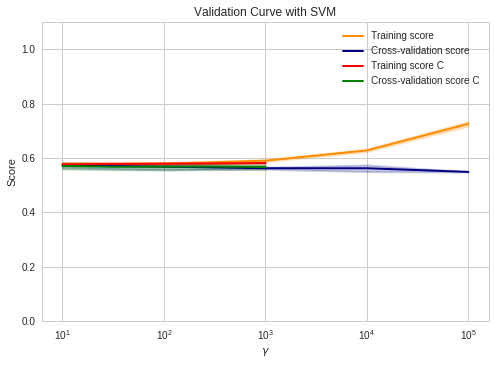

In [18]:
row = df_res.min()
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(1, 3, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=100, gamma_start=100)

C                10000.000000
K                   50.000000
gamma            10000.000000
r                    0.100000
roc_cv               0.761392
roc_train            0.785536
s                    0.500000
stock             1472.000000
roc_log_cv           0.558029
roc_log_train        0.560898
dtype: float64


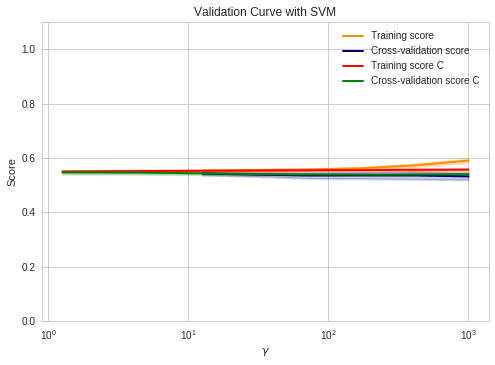

In [15]:
row = df_res.min()
r = row['r']
s = row['s']

gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(0.1, 3, 6), 
                      gamma_range=np.logspace(1.1, 3, 6), c_start=10, gamma_start=10)

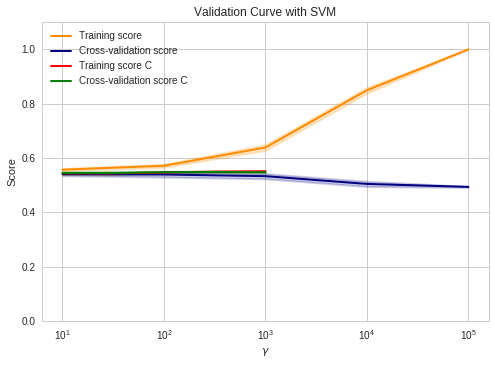

In [16]:
plot_validation_curve(df, c_range=np.logspace(1, 3, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=1000, gamma_start=0.1)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

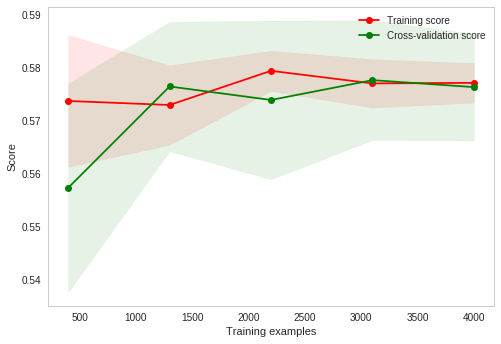

In [20]:
clf = plot_svm_learning_curve(df, C=0.1, gamma=0.1)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
X = df_test.loc[:, gdf_columns]
y = df_test[['mid_price_indicator']].values
c, r = y.shape
y = y.reshape(c, )

from sklearn.metrics import roc_auc_score
pred = clf.predict(X)
print(roc_auc_score(pred, y))
